# __Pacchetto A — “Accesso e capacità di cessazione”__

## __Focus: quanto è “attrezzato” un Paese/una Regione a offrire aiuto (quitline + supporto nei setting + farmaci).__


__1. Mappa del mondo: O-index (0–10) ultimo ≤2022__

- Cosa: indice composito = quitline (1) + supporto in 5 setting (ospedali, cliniche/primary care, comunità, altri setting, “altri”) (max 5) + farmaci legalmente venduti (NRT, Bupropion, Vareniclina, Citisina) (max 4) → 0–10.

- Dataset: Quitline: Access_to_a_toll-free_quit_line

- Setting: support_in_hospitals, ...in_health_clinics_or_primary_care, ...in_the_community, ...in_other_settings, ...in_other_settings

- Farmaci: nicotine_replacement_therapy, Bupropion, Varenicline, Cytisine.

- Collegamento a M/P: analoga alla mappa P-index; confrontabile con la mappa M (delta prevalenza) per pattern grezzi.

__2. Trend 2007–2022 per Regione OMS: mediana O-index__

- Cosa: linee con marker biennali (come in M/P) della mediana dell’O-index per regione OMS + bande IQR (opzionali).

- Insight: mostra se/quanto la capacità cresce nel tempo e dove.

__3. Small multiples (6 pannelli): quota di Paesi con supporto per setting__

- Cosa: per ciascuna Regione OMS, % Paesi che offrono supporto in ospedali / primary care / comunità / altri (4–5 linee per pannello).

- Insight: dove si sta istituzionalizzando la cessazione (es. primary care vs ospedali), coerente con gli small-multiples di P per “venue”.

__4. C1 — Scatter (Paese): O-index (x) vs Prevalenza fumo M (y)__
- colore=Regione + regressione
- Collega l’“offerta” (O) con l’esito (M), parallelo allo scatter P→M che abbiamo già fatto.

## __1. Mappa del mondo: O-index (0–10) ultimo ≤2022__

__Che cos’è e cosa fa vedere__

- È una choropleth dell’“O-index” (0–9): per ogni Paese sommiamo 9 elementi di “cessation support” presenti nei dataset O:

- 1 linea telefonica nazionale (quitline)

- 4 setting con servizi per smettere (primary care/cliniche, ospedali, comunità, altri contesti)

- 4 farmaci (NRT, bupropione, citisina, vareniclina – nel dato WHO sono “legally sold/available”).

- Per ogni Paese prendiamo l’ultimo anno disponibile ≤ 2022 e mostriamo il totale (0=nessun elemento, 9=tutti presenti). Il riquadro a destra elenca i Top 10 per O-index.


__Come leggere i risultati (e coerenza con i dataset)__

- Si vede un gradiente netto: Nord America ed Europa hanno in genere valori alti (7–9/9); molte aree dell’Africa e parte dell’Asia hanno coperture più basse (0–4/9).

- I Paesi nei Top 10 (es. Canada, Germania, Italia, Spagna, Danimarca, Finlandia, ecc.) risultano con 8–9/9: è coerente con quanto ci aspettiamo da sistemi sanitari che**:**

    - dispongono di una quitline nazionale,

    - hanno servizi di cessazione su più setting,

    - e tutti/ quasi tutti i farmaci sono legalmente venduti.

- Alcuni outlier positivi (es. Côte d’Ivoire nel tuo elenco) possono comparire perché i file “medication” misurano “legally sold/available”, non necessariamente accessibilità o rimborso: è comunque coerente con i CSV (noi mappiamo “yes/available/legally/toll-free”→1).

- Ricorda che l’anno è “ultimo ≤2022”: da Paese a Paese può essere diverso (2018, 2020, 2022…), quindi piccole discrepanze rispetto a report che fissano un anno unico sono normali.

- In sintesi: il grafico offre una fotografia globale della capacità di supporto alla cessazione: dove l’indice è alto c’è un’infrastruttura completa (servizi + farmaci), dove è basso mancano uno o più pilastri. La lettura è coerente con la struttura dei dataset O; se vogliamo andare oltre la “presenza legale” e parlare di uso reale o accessibilità, dovremo incrociare con prezzi/rimborso o copertura dei servizi (altri dataset o fonti).

In [7]:
# === O — Grafico O1: Mappa O-index (0–9) + Top 10 paesi ===
import pandas as pd, numpy as np, os, glob, re
import plotly.express as px
from pathlib import Path

YEAR_MAX = 2022

# ---- utility ---------------------------------------------------------------
def pick_col(df, *aliases):
    cols = {c.lower(): c for c in df.columns}
    for a in aliases:
        if a.lower() in cols: 
            return cols[a.lower()]
    raise KeyError(f"Colonna non trovata tra {aliases} in: {list(df.columns)[:10]}...")

def to_binary(series):
    """
    Converte una colonna in 0/1:
    - se numerica: >0 -> 1
    - se testuale: yes/available/legally/toll-free -> 1 ; no/not available/not legally -> 0
    """
    s = series.copy()

    # numerico?
    if pd.api.types.is_numeric_dtype(s):
        return (pd.to_numeric(s, errors="coerce").fillna(0) > 0).astype(int)

    # prova conversione numerica soft (es. "1","0")
    s_num = pd.to_numeric(s, errors="coerce")
    if s_num.notna().any():
        return (s_num.fillna(0) > 0).astype(int)

    # testo
    st = s.astype(str).str.strip().str.lower()
    no = st.str.contains(r"\bno\b|not available|not legally|does not exist|none|absent", na=False)
    yes = st.str.contains(r"\byes\b|available|legally|toll[- ]?free|exists?", na=False)
    # precedenza a "no" se compaiono entrambi
    v = np.where(no, 0, np.where(yes, 1, 0))
    return pd.Series(v, index=s.index, dtype=int)

# ---- dove cercare i CSV ----------------------------------------------------
SEARCH_DIRS = ["O", "./O", ".", "../O"]
all_csv = []
for d in SEARCH_DIRS:
    all_csv += glob.glob(os.path.join(d, "*.csv"))
all_csv = sorted(set(all_csv))

print("[cwd]", os.getcwd())
print("[csv trovati]", len(all_csv))
for f in all_csv:
    if any(k in f.lower() for k in ["help", "medication", "quit"]):
        print(" -", f)

if not all_csv:
    raise SystemExit("CSV non trovati. Controlla la directory di lavoro e il percorso dei file di O.")

# ---- mappa filename -> componente O ----------------------------------------
COMPONENT_PATTERNS = {
    "quitline"       : r"quit[-_ ]?line",
    "primary_care"   : r"health.*clinic|primary.*care",
    "hospitals"      : r"hospitals?",
    "community"      : r"community",
    "other_settings" : r"other.*settings?",
    "nrt"            : r"nicotine.*replacement|nrt",
    "bupropion"      : r"bupropion",
    "cytisine"       : r"cytisin",
    "varenicline"    : r"vareniclin",
}

# match dei file ai componenti (prende il primo che matcha)
files = {}
for comp, pat in COMPONENT_PATTERNS.items():
    hit = [f for f in all_csv if re.search(pat, os.path.basename(f), flags=re.I)]
    if hit:
        files[comp] = hit[0]

# diagnostica componenti
print("\n[Diagnostica] Componenti trovati:")
for comp in COMPONENT_PATTERNS:
    print(f" - {comp:<14}", "OK" if comp in files else "MISSING")

# ---- carica ogni componente in long (ISO3, Country, Year, comp, v) ----------
long_parts = []
diag_rows = []
for comp, path in files.items():
    df = pd.read_csv(path, encoding="utf-8-sig")

    iso_col   = pick_col(df, "SpatialDimValueCode","ISO3","ISO")
    loc_col   = pick_col(df, "Location","Country","SpatialDim")
    year_col  = pick_col(df, "Period","TimeDim","Year")

    # trova una colonna 'valore sì/no'
    cand = None
    for c in ["Value","FactValueNumeric","FactValue","ValueNumeric"]:
        if c in df.columns:
            cand = c; break
    if cand is None:
        # fallback: prendi la prima colonna con cardinalità molto piccola
        small = [c for c in df.columns if df[c].nunique(dropna=False) <= 5]
        cand = small[0] if small else df.columns[-1]

    v = to_binary(df[cand])

    tmp = df[[iso_col, loc_col, year_col]].copy()
    tmp.columns = ["ISO3","Country","Year"]
    tmp["comp"] = comp
    tmp["v"] = v.values
    tmp["Year"] = pd.to_numeric(tmp["Year"], errors="coerce")

    # keep anni validi
    tmp = tmp[tmp["Year"].between(1990, YEAR_MAX)]
    long_parts.append(tmp)

    # diagnostica: anni e % sì
    pct_yes = 100 * (tmp["v"].sum() / max(len(tmp), 1))
    years   = (int(tmp["Year"].min()) if len(tmp) else None, int(tmp["Year"].max()) if len(tmp) else None)
    diag_rows.append((comp, years, f"{pct_yes:.1f}% yes"))

long = pd.concat(long_parts, ignore_index=True)

print("\n[Diagnostica per componente]")
for comp, years, p in diag_rows:
    print(f" - {comp:<14} years={years}   {p}")

# ---- O-index per Paese/Anno (somma dei 9 componenti osservati) --------------
o_by_cty = (long.groupby(["ISO3","Country","Year"])
                 .agg(O_index=("v","sum"), n_obs=("v","size"))
                 .reset_index())

# ---- ultimo anno (≤2022) per Paese -----------------------------------------
last = (o_by_cty[o_by_cty["Year"] <= YEAR_MAX]
        .sort_values(["ISO3","Year"])
        .groupby("ISO3", as_index=False)
        .tail(1))

# ---- TOP 10 paesi -----------------------------------------------------------
top10 = (last.sort_values(["O_index","Year","Country"], ascending=[False, False, True])
              .head(10)
              .assign(rank=lambda d: range(1, len(d)+1)))

print("\n[Top 10 paesi per O-index — ultimo anno ≤ 2022]")
print(top10[["rank","Country","ISO3","Year","O_index","n_obs"]].to_string(index=False))

# ---- Choropleth -------------------------------------------------------------
# Nota: per alcuni territori speciali l'ISO3 di NE/Plotly può differire; qui assumiamo ISO3 standard.
mmin, mmax = int(last["O_index"].min()), int(last["O_index"].max())

fig = px.choropleth(
    last,
    locations="ISO3",
    color="O_index",
    hover_name="Country",
    color_continuous_scale="Blues",
    range_color=(0, 9),
    title=f"O-index (0–9) — ultimo dato ≤ {YEAR_MAX}<br><sup>Somma: quitline + 4 setting + 4 farmaci</sup>",
)
fig.update_geos(showcoastlines=False, showcountries=True, showframe=False, landcolor="rgb(240,240,240)")
fig.update_layout(
    margin=dict(l=10, r=10, t=60, b=10),
    coloraxis_colorbar=dict(title="Indice 0–9"),
    font=dict(size=12)
)

# annotazione Top-10 sintetica
txt = "Top 10 paesi<br>" + "<br>".join(
    [f"{r}. {c} ({oi}/9)" for r,c,oi in top10[["rank","Country","O_index"]].itertuples(index=False)]
)
fig.add_annotation(text=txt, x=0.82, y=0.22, xref="paper", yref="paper",
                   showarrow=False, align="left", bordercolor="rgba(0,0,0,0.2)",
                   borderwidth=1, bgcolor="rgba(255,255,255,0.85)", font=dict(size=11))

fig.show()

# salva PNG se vuoi
Path("O/outputs").mkdir(parents=True, exist_ok=True)
try:
    fig.write_image("O/outputs/O_index_worldmap.png", scale=2)  # richiede kaleido
except Exception:
    pass


[cwd] c:\Users\cola0\Desktop\progetto visualizzazione scientifica\O
[csv trovati] 18
 - ../O\Tobacco_control_offer_help_Access_to_a_toll-free_quit_line.csv
 - ../O\Tobacco_help_smoking_cessation_support_is_available_in_health_clinics_or_other_primary_care_facilities.csv
 - ../O\Tobacco_help_smoking_cessation_support_is_available_in_hospitals.csv
 - ../O\Tobacco_help_smoking_cessation_support_is_available_in_other_settings.csv
 - ../O\Tobacco_help_smoking_cessation_support_is_available_in_the_community.csv
 - ../O\Tobacco_medication_legally_sold_Bupropion.csv
 - ../O\Tobacco_medication_legally_sold_Cytisine.csv
 - ../O\Tobacco_medication_legally_sold_nicotine_replacement_therapy.csv
 - ../O\Varenicline_-_legally_sold_(Tobacco_control_Offer_help).csv
 - .\Tobacco_control_offer_help_Access_to_a_toll-free_quit_line.csv
 - .\Tobacco_help_smoking_cessation_support_is_available_in_health_clinics_or_other_primary_care_facilities.csv
 - .\Tobacco_help_smoking_cessation_support_is_available_in_h

## __2. Trend 2007–2022 per Regione OMS: mediana O-index__


[debug] Cartella O: c:\Users\cola0\Desktop\progetto visualizzazione scientifica\O
[debug] Cartella M: c:\Users\cola0\Desktop\progetto visualizzazione scientifica\M


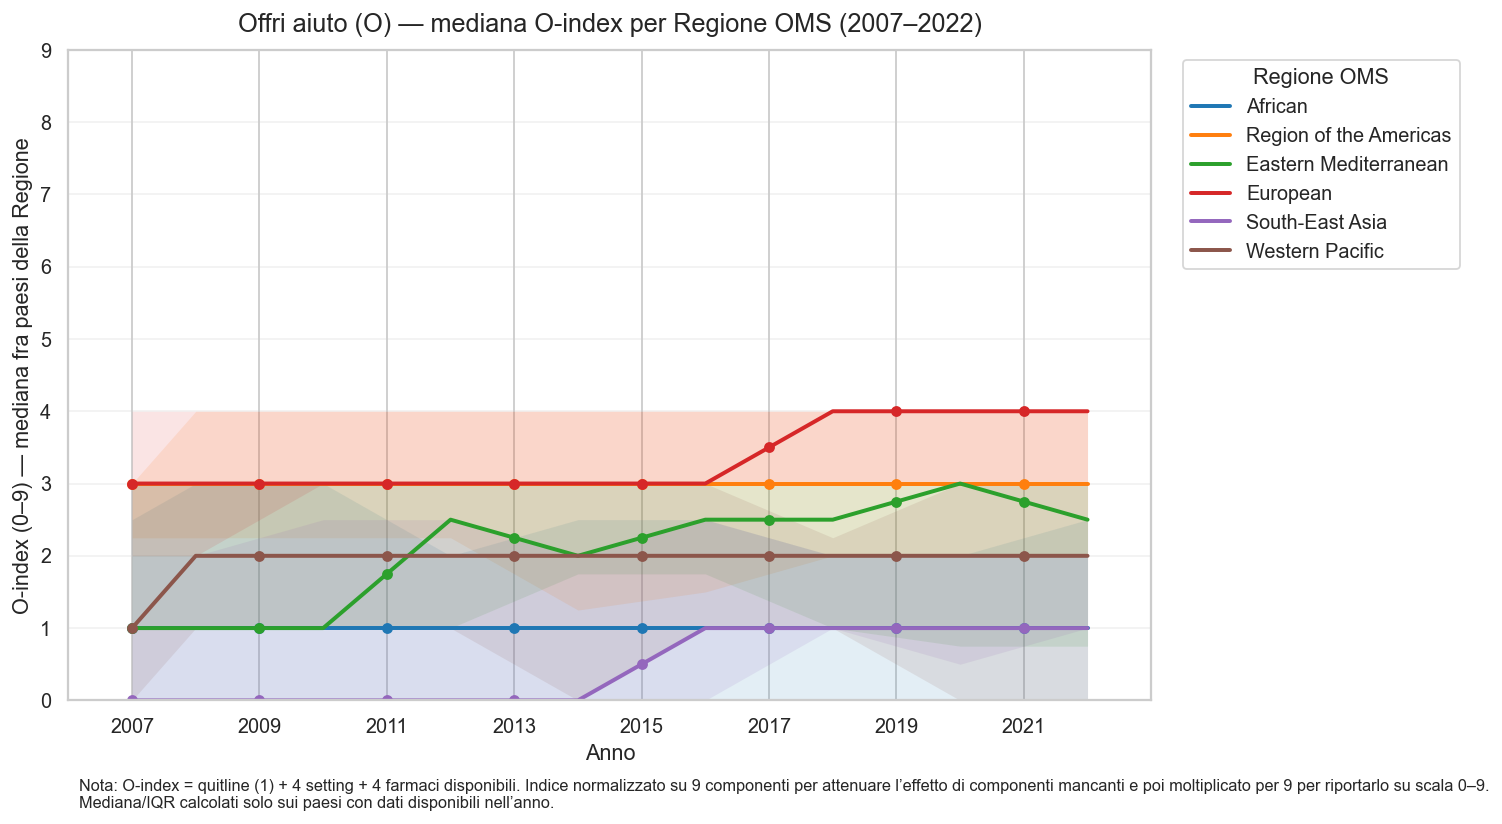

[salvato] c:\Users\cola0\Desktop\progetto visualizzazione scientifica\O\outputs\offerhelp_trend_median_by_region.png


In [18]:
# === O — Grafico #2: Trend 2007–2022 per Regione OMS — mediana O-index (0–9) ===
import pandas as pd, numpy as np, glob, re, os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# -------------------- Parametri --------------------
YEAR_MIN, YEAR_MAX = 2007, 2022
PALETTE = {
    "African Region": "#1f77b4",
    "Region of the Americas": "#ff7f0e",
    "Eastern Mediterranean Region": "#2ca02c",
    "European Region": "#d62728",
    "South-East Asia Region": "#9467bd",
    "Western Pacific Region": "#8c564b",
}
REGION_ORDER = list(PALETTE.keys())

# componenti dell'O-index: 1 quitline + 4 setting + 4 farmaci = 9
COMPONENTS = {
    "quitline"     : "Tobacco_control_offer_help_Access_to_a_toll-free_quit_line.csv",
    "primary_care" : "Tobacco_help_smoking_cessation_support_is_available_in_health_clinics_or_other_primary_care_facilities.csv",
    "hospitals"    : "Tobacco_help_smoking_cessation_support_is_available_in_hospitals.csv",
    "other_settings":"Tobacco_help_smoking_cessation_support_is_available_in_other_settings.csv",
    "community"    : "Tobacco_help_smoking_cessation_support_is_available_in_the_community.csv",
    "nrt"          : "Tobacco_medication_legally_sold_nicotine_replacement_therapy.csv",
    "bupropion"    : "Tobacco_medication_legally_sold_Bupropion.csv",
    "varenicline"  : "Varenicline_-_legally_sold_(Tobacco_control_Offer_help).csv",
    "cytisine"     : "Tobacco_medication_legally_sold_Cytisine.csv",
}
N_COMPONENTS = len(COMPONENTS)  # =9

def yesno_to_bin(s):
    s = s.astype(str).str.strip().str.lower()
    return s.map({"yes":1,"no":0}).fillna(0).astype(int)

def pick(df,*aliases):
    m = {c.lower(): c for c in df.columns}
    for a in aliases:
        if a.lower() in m: return m[a.lower()]
    raise KeyError(f"Colonna non trovata in {df.columns.tolist()} (cerco {aliases})")

def norm_region(x):
    s = str(x).strip().lower()
    if s in {"afr","african region","africa"}: return "African Region"
    if s in {"amr","region of the americas","americas"}: return "Region of the Americas"
    if s in {"emr","eastern mediterranean region","eastern mediterranean"}: return "Eastern Mediterranean Region"
    if s in {"eur","european region","europe"}: return "European Region"
    if s in {"sear","south-east asia region","south-east asia","south east asia"}: return "South-East Asia Region"
    if s in {"wpr","western pacific region","western pacific"}: return "Western Pacific Region"
    return np.nan

# -------------------- Trova cartelle --------------------
O_DIR = Path.cwd()
# cerca M sia a fianco di O/ sia due livelli sopra (dipende da dove lanci il notebook)
M_CANDIDATES = [O_DIR.parent/"M", Path("../M"), Path("../../M"), Path("M")]
M_DIR = next((p for p in M_CANDIDATES if (p.exists() and any(p.glob("*age*standard*.csv")))), None)
if M_DIR is None:
    raise SystemExit("Non trovo CSV in una cartella M adiacente. Attesi file tipo '*age*standard*.csv'.")

print(f"[debug] Cartella O: {O_DIR}")
print(f"[debug] Cartella M: {M_DIR}")

# -------------------- M: mappa ISO3 -> Regione --------------------
m_candidates = sorted(M_DIR.glob("*age*standard*.csv"))
dfm = pd.read_csv(m_candidates[0], encoding="utf-8-sig")
iso_m   = pick(dfm, "SpatialDimValueCode","ISO3","ISO")
regionm = next((c for c in dfm.columns if c.lower() in {"parentlocation","who region","who_region","region"}), None)
if not regionm:
    raise SystemExit("Nel file di M non trovo la colonna di regione OMS.")
iso_region = (dfm[[iso_m, regionm]].rename(columns={iso_m:"ISO3", regionm:"Region"})
                .dropna().drop_duplicates())
iso_region["Region"] = iso_region["Region"].map(norm_region)
iso_region = iso_region.dropna().drop_duplicates("ISO3")

# -------------------- O: carica i 9 CSV e costruisci indice --------------------
long_parts = []
for key, fname in COMPONENTS.items():
    fpath = O_DIR / fname
    if not fpath.exists():
        raise SystemExit(f"File mancante in O/: {fname}")

    d = pd.read_csv(fpath, encoding="utf-8-sig")
    year = pick(d, "Period","TimeDim","Year")
    iso  = pick(d, "SpatialDimValueCode","ISO3","ISO")
    loc  = pick(d, "Location","Country","SpatialDim")
    val  = pick(d, "Value","FactValueNumeric","factvaluenumeric")

    tmp = d[[iso, loc, year, val]].rename(columns={iso:"ISO3", loc:"Country", year:"Year", val:"Value"}).copy()
    # 'Value' può essere Yes/No o 1/0: normalizziamo
    if tmp["Value"].dtype == object:
        tmp["v"] = yesno_to_bin(tmp["Value"])
    else:
        tmp["v"] = pd.to_numeric(tmp["Value"], errors="coerce").fillna(0).clip(0,1).astype(int)

    tmp["comp"] = key
    tmp["Year"] = pd.to_numeric(tmp["Year"], errors="coerce")
    tmp = tmp[(tmp["Year"]>=YEAR_MIN) & (tmp["Year"]<=YEAR_MAX)]
    long_parts.append(tmp[["ISO3","Country","Year","comp","v"]])

long = pd.concat(long_parts, ignore_index=True)
# attacca la Regione OMS
long = long.merge(iso_region, on="ISO3", how="left").dropna(subset=["Region"])

# indice normalizzato per Paese-anno: (somma v / componenti osservati) * 9
by_cy = (long.groupby(["ISO3","Country","Region","Year"], observed=True)
              .agg(v_sum=("v","sum"), n_obs=("v","size"))
              .reset_index())
by_cy["O_index_norm"] = (by_cy["v_sum"] / by_cy["n_obs"]) * N_COMPONENTS

# -------------------- Aggregazione per Regione-anno (mediana + IQR) --------------------
agg = (by_cy.groupby(["Region","Year"], observed=True)
            .agg(median=("O_index_norm","median"),
                 q25=("O_index_norm", lambda s: s.quantile(0.25)),
                 q75=("O_index_norm", lambda s: s.quantile(0.75)),
                 n_countries=("O_index_norm","size"))
            .reset_index())
agg["Region"] = pd.Categorical(agg["Region"], categories=REGION_ORDER, ordered=True)
agg = agg.sort_values(["Region","Year"])

# -------------------- Plot --------------------
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(11.5,6.5), dpi=130)

tick_years = list(range(2007, 2023, 2))

for reg in REGION_ORDER:
    sub = agg[agg["Region"]==reg]
    if sub.empty: 
        continue
    c = PALETTE[reg]
    # area IQR
    ax.fill_between(sub["Year"], sub["q25"], sub["q75"], color=c, alpha=0.12, linewidth=0)
    # linea mediana
    ax.plot(sub["Year"], sub["median"], color=c, linewidth=2.2, label=reg.replace(" Region",""))
    # marker sui tick (interpolazione)
    s = pd.Series(sub["median"].values, index=sub["Year"].values).sort_index()
    s_interp = (s.reindex(sorted(set(s.index).union(tick_years)))
                  .interpolate(method="index")
                  .reindex(tick_years))
    ax.plot(s_interp.index, s_interp.values, linestyle="", marker="o", color=c, markersize=5)

ax.set_title("Offri aiuto (O) — mediana O-index per Regione OMS (2007–2022)", fontsize=14, pad=10)
ax.set_xlabel("Anno", fontsize=12)
ax.set_ylabel("O-index (0–9) — mediana fra paesi della Regione", fontsize=12)
ax.set_xlim(2006, 2023)
ax.set_xticks(tick_years)
ax.set_ylim(0, 9)
ax.grid(True, axis="y", alpha=0.25)

leg = ax.legend(title="Regione OMS", ncols=1, bbox_to_anchor=(1.02,1), loc="upper left", frameon=True)

note = ("Nota: O-index = quitline (1) + 4 setting + 4 farmaci disponibili. "
        "Indice normalizzato su 9 componenti per attenuare l’effetto di componenti mancanti "
        "e poi moltiplicato per 9 per riportarlo su scala 0–9.\n"
        "Mediana/IQR calcolati solo sui paesi con dati disponibili nell’anno.")
ax.text(0.01, -0.12, note, transform=ax.transAxes, fontsize=9, va="top", ha="left")

plt.tight_layout()
out_dir = O_DIR / "outputs"
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "offerhelp_trend_median_by_region.png"
plt.savefig(out_path, bbox_inches="tight")
plt.show()
print(f"[salvato] {out_path}")


In [ ]:
# === O — Heatmap: quota di Paesi con ogni componente “Offer help” per Regione OMS (ultimo anno ≤2022) ===
import pandas as pd, numpy as np, glob, os, re
import seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path

O_DIR = "O"          # cartella con i 9 CSV dell'Offer help
M_DIR = "M"          # ci serve per mappa ISO3 -> Regione OMS
YEAR_MAX = 2022

# -------- util --------
def yesno_to_bin(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip().str.lower()
    # gestisce anche '1/0', 'true/false', 'legally sold' ecc. (qualsiasi cosa non-yes -> 0)
    return s.isin({"yes", "1", "true"}).astype(int)

def pick_col(df, *aliases):
    cols = {c.lower(): c for c in df.columns}
    for a in aliases:
        if a.lower() in cols: 
            return cols[a.lower()]
    raise KeyError(f"Colonna non trovata. Presenti: {list(df.columns)}")

def norm_region(x):
    x = str(x).strip().lower()
    if x in {"afr","african region","africa"}:                          return "African Region"
    if x in {"amr","region of the americas","americas"}:               return "Region of the Americas"
    if x in {"emr","eastern mediterranean region","eastern mediterranean"}: return "Eastern Mediterranean Region"
    if x in {"eur","european region","europe"}:                        return "European Region"
    if x in {"sear","south-east asia region","south-east asia"}:       return "South-East Asia Region"
    if x in {"wpr","western pacific region","western pacific"}:        return "Western Pacific Region"
    return np.nan

def get_iso_region_map_from_M():
    # prendo un CSV qualsiasi della sezione M con ISO3 e regione
    candidates = sorted(glob.glob(os.path.join(M_DIR, "*.csv")))
    if not candidates:
        raise SystemExit(f"ATTENZIONE: non trovo CSV in ./{M_DIR} per ricavare la regione OMS.")
    df = pd.read_csv(candidates[0], encoding="utf-8-sig")
    iso = pick_col(df, "SpatialDimValueCode","ISO3","ISO")
    reg = next((c for c in df.columns if c.lower() in {"parentlocation","who region","who_region","region"}), None)
    if not reg:
        raise SystemExit("Non trovo la colonna della Regione OMS in M/*.csv")
    out = df[[iso,reg]].dropna().drop_duplicates()
    out.columns = ["ISO3","Region"]
    out["Region"] = out["Region"].map(norm_region)
    return out.dropna().drop_duplicates("ISO3")

iso_region = get_iso_region_map_from_M()

# -------- mappa pattern -> componente --------
COMP_PATTERNS = {
    "quitline"         : r"quit[_\- ]?line",
    "setting_primary"  : r"primary[_\- ]?care|health[_\- ]?clinics",
    "setting_hospitals": r"hospitals?",
    "setting_community": r"in[_\- ]the[_\- ]community",
    "setting_other"    : r"other[_\- ]settings",
    "drug_nrt"         : r"nicotine[_\- ]replacement[_\- ]therapy",
    "drug_bupropion"   : r"bupropion",
    "drug_varenicline" : r"varenicline",
    "drug_cytisine"    : r"cytisine",
}

COMP_LABELS = {
    "quitline"         : "Quitline",
    "setting_primary"  : "Setting: primary care",
    "setting_hospitals": "Setting: hospitals",
    "setting_community": "Setting: community",
    "setting_other"    : "Setting: other settings",
    "drug_nrt"         : "Drug: NRT",
    "drug_bupropion"   : "Drug: bupropion",
    "drug_varenicline" : "Drug: varenicline",
    "drug_cytisine"    : "Drug: cytisine",
}

# -------- trova i file --------
all_csv = sorted(glob.glob(os.path.join(O_DIR, "*.csv")))
found = {}
for comp, pat in COMP_PATTERNS.items():
    hit = [f for f in all_csv if re.search(pat, os.path.basename(f), flags=re.I)]
    if hit:
        found[comp] = hit[0]

print("[diagnostica] file trovati:")
for k,v in found.items(): 
    print(f" - {k:17s} -> {os.path.basename(v)}")
missing = [k for k in COMP_PATTERNS if k not in found]
if missing:
    print("\n[attenzione] mancanti:", ", ".join(missing))

# -------- long per ultimo anno di ogni Paese/componente --------
rows = []
for comp, path in found.items():
    df = pd.read_csv(path, encoding="utf-8-sig")

    year = pick_col(df, "Period","TimeDim","Year")
    iso  = pick_col(df, "SpatialDimValueCode","ISO3","ISO")
    val  = "Value" if "Value" in df.columns else (
           "FactValueNumeric" if "FactValueNumeric" in df.columns else None)
    if val is None:
        raise SystemExit(f"Nessuna colonna valori in {os.path.basename(path)}")

    tmp = df[[iso, year, val]].copy()
    tmp.columns = ["ISO3","Year","Value"]
    tmp["Year"] = pd.to_numeric(tmp["Year"], errors="coerce")
    tmp = tmp[tmp["Year"] <= YEAR_MAX].dropna(subset=["ISO3","Year"])

    # normalizzo valore a 0/1
    if tmp["Value"].dtype.kind in "biufc":
        tmp["v"] = (pd.to_numeric(tmp["Value"], errors="coerce").fillna(0) > 0).astype(int)
    else:
        tmp["v"] = yesno_to_bin(tmp["Value"])

    # ultimo anno per Paese
    tmp = (tmp.sort_values("Year")
               .groupby("ISO3", as_index=False)
               .tail(1)[["ISO3","Year","v"]]
               .assign(component=comp))
    rows.append(tmp)

long = pd.concat(rows, ignore_index=True)
long = long.merge(iso_region, how="left", on="ISO3").dropna(subset=["Region"])

# -------- quota per Regione e componente --------
shares = (long.groupby(["Region","component"])
               .agg(share=("v", lambda s: 100*s.mean()),
                    n_countries=("v","size"))
               .reset_index())

# pivot per heatmap (componenti come righe, regioni come colonne)
pivot = (shares.pivot(index="component", columns="Region", values="share")
               .reindex(index=list(COMP_LABELS.keys()))
               .rename(index=COMP_LABELS)
               .fillna(0))

# -------- PLOT --------
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 6.5), dpi=140)

sns.heatmap(pivot, annot=True, fmt=".0f", cmap="Blues",
            cbar_kws={"label": "Quota di Paesi (%)"}, ax=ax, vmin=0, vmax=100)

ax.set_title("Offer help (O) — quota di Paesi con componente attiva\nUltimo dato disponibile ≤ 2022")
ax.set_xlabel("Regione OMS")
ax.set_ylabel("Componente")
plt.tight_layout()

Path(os.path.join(O_DIR,"outputs")).mkdir(parents=True, exist_ok=True)
out_path = os.path.join(O_DIR, "outputs", "offerhelp_component_heatmap.png")
plt.savefig(out_path, bbox_inches="tight", dpi=160)
plt.show()

print("\n[DEBUG] Tabella quote (%) per controllo:\n")
display(pivot.round(0))


SystemExit: ATTENZIONE: non trovo CSV in ./M per ricavare la regione OMS.

C:\Users\cola0\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3585: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.

